## Design source wavelets for SEM simulations

Francois Lavoue, 19 May 2021  
Last updated FL, 5 July 2022

## Modules

In [1]:
# Backward compatibility of print() between Python 2 and 3
#from __future__ import print_function

# Plot figures directly in the notebook
%matplotlib notebook

# Plot defaults
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')                 # Matplotlib style sheet
plt.rcParams['figure.figsize'] = 10,5

# Font sizes
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
%%javascript
// Disable Auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines){return false;}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import struct
import sys
import os
from scipy import signal
from obspy.signal import filter

/home/iman/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/iman/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/iman/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 2.22.1ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/iman/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


---

## User parameters

In [4]:
# time parameters
dt = 1e-3   # (s)
tmax = 60.0     # (s)

# source type
source_type = "lowpass"   # "dirac", "ricker", "gaussian", "lowpass", or "single-lowpass"

# central frequency (for Ricker), or max. frequency (for Gaussian or lowpass-filtered Dirac)
f0 = 2.0   #2.0   #0.5   #0.625   # (Hz)

format_sem = "EFISPEC"   # "SEM46" or "EFISPEC"


In [5]:
# output file name
dir_ou = ("input_files/%s_input_files/%s_inputs_per_file_types/sourcesnew" % (format_sem, format_sem))

if not os.path.isdir(dir_ou) :
    os.makedirs(dir_ou)
print(dir_ou)

input_files/EFISPEC_input_files/EFISPEC_inputs_per_file_types/sourcesnew


---

## Derived parameters

In [6]:
# time vector
vt = np.arange(0.0, tmax+0.1*dt, dt)
nt = len(vt)

# frequency vector
fmax = 0.5/dt
df = 1/tmax
vf = np.arange(0.0, fmax+0.1*df, df)
nf = len(vf)

print("nt = %i" % (nt))
print("tmin = %f" % (vt.min()))
print("tmax = %f , %f" % (tmax, vt.max()))

print("\nnf = %i" % (nf))
print("df = %f" % (df))
print("fmax = %f , %f" % (fmax, vf.max()))

nt = 60001
tmin = 0.000000
tmax = 60.000000 , 60.000000

nf = 30001
df = 0.016667
fmax = 500.000000 , 500.000000


---

## Design source wavelet

In [7]:
if source_type == "dirac" :
    st = signal.unit_impulse(nt, idx=0, dtype=np.float)
    
elif source_type == "lowpass" :
    # lowpass-filtered dirac
    st = signal.unit_impulse(nt, idx=0, dtype=np.float)
    # FL's personal recipe: filter repeatedly, using both zero-phase and non-zero-phase filters,
    #                       until we get something nice in terms of cutoff and temporal support
    for i_filter in range(0,6) :
        st = filter.lowpass(st, f0, 1/dt, corners=4, zerophase=False)
    for i_filter in range(0,5) :
        st = filter.lowpass(st, f0, 1/dt, corners=4, zerophase=True)
    # normalize
    st = st / max(abs(st))
    
elif source_type == "single-lowpass" :
    # lowpass-filtered dirac
    st = signal.unit_impulse(nt, idx=0, dtype=np.float)
    # filter once
    st = filter.lowpass(st, f0, 1/dt, corners=10, zerophase=False)
    # normalize
    st = st / max(abs(st))
    
elif source_type == "gaussian" :
    # scipy.signal.gausspulse(t, fc=1000, bw=0.5, bwr=- 6, tpr=- 60, retquad=False, retenv=False)[source]
    # Return a Gaussian modulated sinusoid:
    #   exp(-a t^2) exp(1j*2*pi*fc*t).
    # Example:
    #   i, q, e = signal.gausspulse(t, fc=5, retquad=True, retenv=True)
    #   plt.plot(t, i, t, q, t, e, '--')
    t0 = 1.5*np.sqrt(6.)/(np.pi*f0)
    t0 = 3*t0
    stc, st = signal.gausspulse(vt-t0, fc=f0, retenv=True)
                      
elif source_type == "ricker" :
    ## from scipy.signal (FL: not sure how to relate the width "a" to f0 here...)
    #st = signal.ricker(nt, a)
    
    ## (from https://subsurfwiki.org/wiki/Ricker_wavelet)
    #st = (1.0 - 2.0*(np.pi**2)*(f0**2)*((vt-1/f0)**2)) * np.exp(-(np.pi**2)*(f0**2)*((vt-1/f0)**2))

    # (from Seiscope's ricker.f90, same as above but with correct t0)
    t0 = 1.5*np.sqrt(6.)/(np.pi*f0)
    a2 = (np.pi*f0*(vt-t0))**2
    st = (1 - 2*a2)*np.exp(-a2)
    
# FFT
sf = np.fft.rfft(st)

if source_type == "gaussian" :
    sfc = np.fft.rfft(stc)

AttributeError: module 'numpy' has no attribute 'float'

In [8]:
if False :
    # additionnal Ricker...
    # (from Seiscope's ricker.f90, same as above but with correct t0)
    f02 = 20.0   # (Hz)
    t02 = 1.5*np.sqrt(6.)/(np.pi*f02)
    a2 = (np.pi*f02*(vt-t02))**2
    st2 = (1 - 2*a2)*np.exp(-a2)
    sf2 = np.fft.rfft(st2)
    
    # additional lowpass-filtered Dirac...
    std = signal.unit_impulse(nt, idx=0, dtype=np.float)
    stdf = filter.lowpass(std, 50.0, 1/dt, corners=10, zerophase=False)
    stdf = stdf/max(abs(stdf))
    sfdf = np.fft.rfft(stdf)
    
    # additional Gaussian...
    f03 = 35.0   # (Hz)
    t03 = 1.5*np.sqrt(6.)/(np.pi*f03)
    t03 = 3*t03
    stc3, st3 = signal.gausspulse(vt-t03, fc=f03, retenv=True)
    sf3 = np.fft.rfft(st3)
    sfc3 = np.fft.rfft(stc3)

---

## Plot source wavelet

<IPython.core.display.Javascript object>


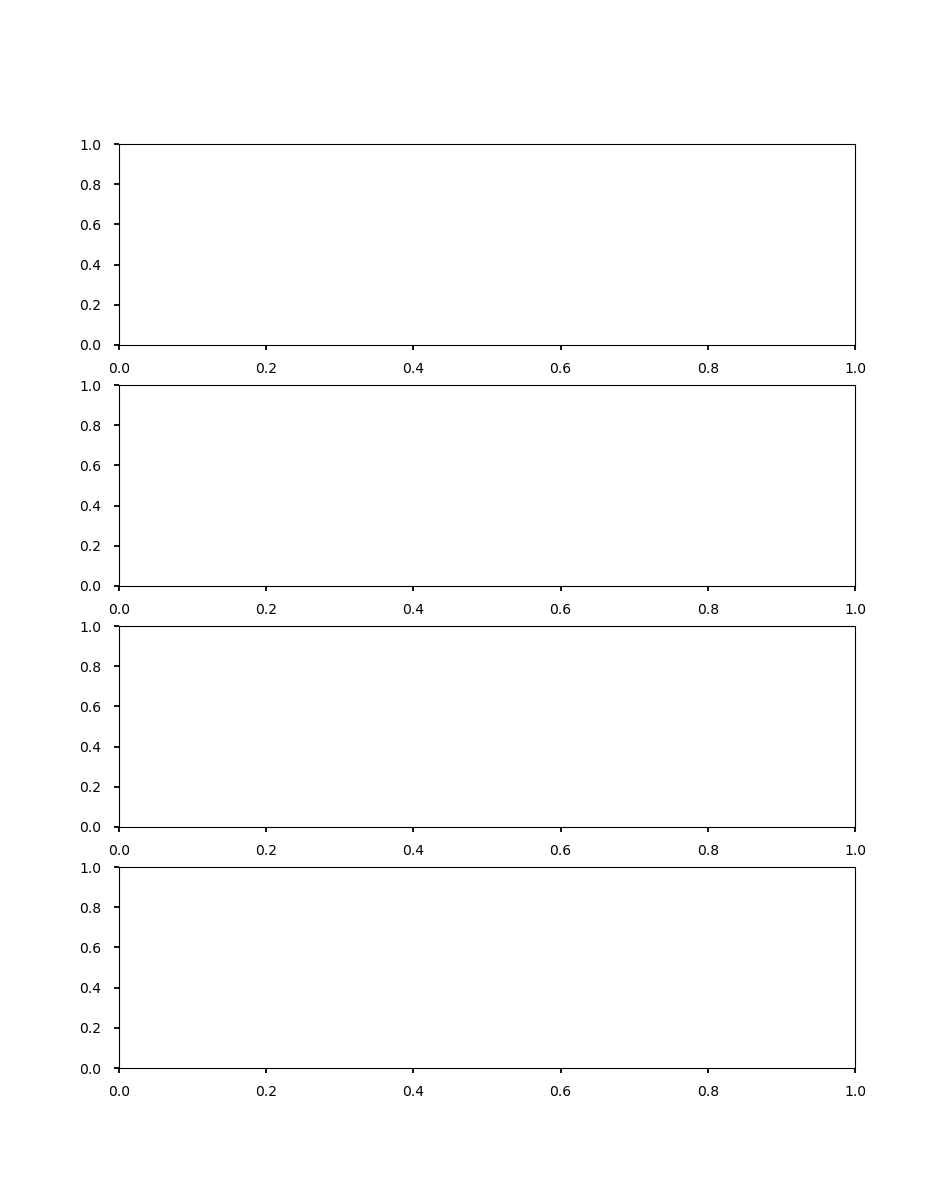

NameError: name 'st' is not defined

In [9]:
nrows = 4
fig, axes = plt.subplots(nrows=nrows, figsize=(9.5,3*nrows))

# plot time-domain signal
ax = axes[0]
ax.plot(vt, st)
ax.set_xlabel("Time (s)")
ax.set_xlim(0.0, tmax)
ax.set_ylim(-1.10, 1.10)

# plot amplitude spectrum (log-log axis)
ax = axes[1]
ax.loglog(vf, abs(sf))
ax.set_xlabel("Frequency (Hz)")
#ax.set_xlim(0.0, 5.0*f0)

# plot amplitude spectrum (linear axis)
ax = axes[2]
ax.plot(vf, abs(sf))
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0.0, 3*f0)

# plot phase spectrum (linear axis)
ax = axes[3]
ax.plot(vf, np.angle(sf))
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0.0, 3*f0)

if False :
    ax = axes[0]
    ax.plot(vt, stc)
    ax.plot(vt, st2)
    ax.plot(vt, stdf)
    #ax.plot(vt, st3)
    #ax.plot(vt, stc3)
    
    ax = axes[1]
    ax.plot(vf, abs(sfc))
    ax.plot(vf, abs(sf2))
    ax.plot(vf, abs(sfdf))
    #ax.plot(vf, abs(sf3))
    #ax.plot(vf, abs(sfc3))
    
# common axis tuning
for ax in axes :
    ax.set_ylabel("Amplitude")
    ax.grid(color="gray", linestyle="--", alpha=0.2)
axes[-1].set_ylabel("Phase (rad)")

# general tuning
plt.tight_layout()

#ax.get_xaxis().get_major_formatter().set_useOffset(False)
#plt.draw()

In [10]:
## zoom
#axes[0].set_xlim(0.0, 0.2)
#axes[1].set_xlim(0.0, 60.)

---

## Print to file

In [11]:
# output file name
if source_type == "dirac" :
    file_ou = ("%s/f%s_nt%i" % (dir_ou, source_type, nt))
elif source_type == "lowpass" :
    file_ou = ("%s/fdirac_lowpass-%gHz_nt%i_dt%gms" % (dir_ou, f0, nt, dt*1e3))
elif source_type == "gaussian" :
    file_ou = ("%s/f%s_fmax-%gHz_nt%i_dt%gms" % (dir_ou, source_type, f0, nt, dt*1e3))
else :
    file_ou = ("%s/f%s_%gHz_nt%i_dt%gms" % (dir_ou, source_type, f0, nt, dt*1e3))

print(file_ou)

input_files/EFISPEC_input_files/EFISPEC_inputs_per_file_types/sourcesnew/fdirac_lowpass-2Hz_nt60001_dt1ms


In [12]:
if format_sem == "SEM46" :
# print to binary file for SEM46

    if not os.path.exists(file_ou+".bin") :
        print("print to file:\n%s.bin" % file_ou)
        s = struct.pack('f'*len(st), *st)
        fid = open(file_ou+".bin",'wb')
        fid.write(s)
        fid.close()
        del s

    else :
        print("check against file:\n%s.bin" % file_ou)
        sc = np.fromfile(file_ou+".bin", dtype=np.float32)
        if np.sum((st-sc)**2)/np.sum(st**2) > 1e-6 :
            sys.exit("Error: signal differs from existing file.")
        else :
            print("OK")
        del sc
    
elif format_sem == "EFISPEC" :
# print to ASCII text file for EFISPEC

    if not os.path.exists(file_ou+".txt") :
        print("print to file:\n%s.txt" % file_ou)
        fid = open(file_ou+".txt",'wt')
        for (ti, si) in zip(vt, st) :
            fid.write("%15.7e %15.7e\n" % (ti, si))
        del ti, si
        fid.close()
        
    else :
        print("check against file:\n%s.txt" % file_ou)
        d1 = np.concatenate((vt.reshape(len(vt),1),st.reshape(len(vt),1)), axis=1)
        d2 = np.loadtxt(file_ou+".txt")
        diff1 = np.sum((d1[:,0]-d2[:,0])**2)/np.sum(d1[:,0]**2)
        diff2 = np.sum((d1[:,1]-d2[:,1])**2)/np.sum(d1[:,1]**2)
        if diff1 > 1e-6 or diff2 > 1e-6 :
            sys.exit("Error: signal differs from existing file.")
        else :
            print("OK")
            

print to file:
input_files/EFISPEC_input_files/EFISPEC_inputs_per_file_types/sourcesnew/fdirac_lowpass-2Hz_nt60001_dt1ms.txt


NameError: name 'st' is not defined